# Sprint12
## 2次元の畳み込みニューラルネットワークスクラッチ

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Using TensorFlow backend.
/Users/akishimasaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/akishimasaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/akishimasaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 =

In [2]:
(X_train,y_train),(X_test,y_test)=mnist.load_data()
X_train,X_test=X_train.reshape(-1,784),X_test.reshape(-1,784)
X_train,X_test=X_train.astype(float)/255,X_test.astype(float)/255

In [3]:
enc=OneHotEncoder(handle_unknown='ignore',sparse=False)
y_train=enc.fit_transform(y_train[:,np.newaxis])
y_test=enc.transform(y_test[:,np.newaxis])

In [4]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2)

## 【問題1】2次元畳み込み層の作成

In [5]:

class Conv2d:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None
        self.fout = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        out_h,out_w = self.stride(x)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(1, -1).T

        out = np.dot(col, col_W) + self.b
        fout = Flatten(out,N, out_h, out_w)
        self.fout=fout
        out = self.fout.forward.transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        
#         FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, 1)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.fout.backward(self.dW.transpose(1, 0))

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

## 【問題2】2次元畳み込み後の出力サイズ

In [6]:
def stride(self,x):
    FN, C, FH, FW = self.W.shape
    N, C, H, W = x.shape
    out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
    out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
    return out_h,out_w

In [7]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item * self.batch_size
        p1 = item * self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = self._counter * self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [8]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.x = None
        self.dW = None
        self.dB = None
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.x = X.copy() #入力を引数で渡す。
        
        A = np.dot(X, self.W) + self.B
#         print("A",A.shape)
        return A
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dA = np.array(dA)
        dZ = np.dot(dA, self.W.T)#重みの形状の転置を行なって、それをdoutでdotする。
        self.dW = np.dot(self.x.T, dA)# 入力の形状の転置を行なって、それをdoutでdotする。
        self.dB = dA
        # 更新
        self = self.optimizer.update(self)
        return dZ

In [9]:
class Affine:
    def __init__(self,W,b):
        self.W=W
        self,b=b
        self.x=None
        self.dW=None
        self.db=None
        
    def forward(self,x):
        self.x=x
        out=np.dot(x,self.W)
        
        return out
    
    def backward(self,dout):
        dx=np.dot(dout,self.W.T)
        self.dW=np.dot(self.x.T,dout)
        self.db=np.sum(dout,axis=0)
        
        return dx

In [10]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2)
        return B

In [11]:
def softmax(A):
        """
        softmap関数
        """
        if A.ndim == 2:
            A = A.T
            A = A - np.max(A, axis=0)
            y = np.exp(A) / np.sum(np.exp(A), axis=0)
            return y.T

        A = A - np.max(A)
        return np.exp(A) / np.sum(np.exp(A))

In [12]:
class Softmax:
    def __init__(self):#インスタンス変数の初期化
        self.loss = None # 損失
        self.y = None # softmaxの出力
        self.t = None # 教師データ
        
    def forward(self,x):
        self.y = softmax(x) # softmax関数の出力
        return self.y #交差エントロピー誤差のインスタンス変数を返す。
    
    def backward(self,Z3,Y):
        self.y = Z3
        self.t = Y
        self.loss = cross_entropy_error(self.y, self.t) 
        batch_size = self.t.shape[0] #教師データの数を取得する
        dx = (self.y - self.t) / batch_size #教師データの数で割り算する。
        dx = np.array(dx)
        return dx, self.loss

In [13]:
class XavierInitializer:
    """
    Xavierによるシンプルな初期化
    Parameters
    ----------
   
    """
    def __init__(self,sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = 1.0/np.sqrt(n_nodes1) * np.random.randn(n_nodes1,n_nodes2)
        return W

    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = 1.0/np.sqrt(n_nodes2) * np.random.randn(n_nodes2)
        return B

In [14]:
class HeInitializer:
    """
    Heによるシンプルな初期化
    Parameters
    ----------
    
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = np.sqrt(2.0/n_nodes1) * np.random.randn(n_nodes1,n_nodes2)
        return W

    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.sqrt(2.0/n_nodes2) * np.random.randn(n_nodes2)
        return B


In [15]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W = layer.W - self.lr * layer.dW/layer.dB.shape[0]
        layer.B = layer.B - self.lr * layer.dB.mean(axis=0)
        return layer

In [16]:
class AdaGrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.h = None
        self.h2 = None
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        self.h = self.h - layer.dW/layer.dB.shape[0] * layer.dW / layer.dB.shape[0]
        layer.W = layer.W - self.lr * 1/np.sqrt(self.h) * layer.dW / layer.dB.shape[0]
        self.h2 = self.h2 - layer.dB/layer.dB.mean(axis=0) * layer.dB / layer.dB.mean(axis=0) 
        layer.B = layer.B - self.lr * 1/np.sqrt(self.h2) * layer.dB / layer.dB.mean(axis=0)
        return layer

In [17]:
def sigmoid(X):
    return 1.0/ (1 + np.exp(-X))

In [18]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        dx = np.array(dx)
        return dx

In [19]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [20]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self):
        dx = [ 1 if self.mask > 0 else 0 ]

        return dx

In [21]:
#im2col,3次元データ（４次元データ）を２次元に変換する処理
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

    

In [22]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

[np.pad使い方](https://qiita.com/horitaku1124/items/6ae979b21ddc7256b872)

In [23]:
class ScratchDeepNeuralNetrowkClassifier:
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self):
        self.lr = 0.01
        self.sigma = 0.01 # ガウス分布の標準偏差
        batch_size = 10 # バッチサイズ
        self.n_features = 784 # 特徴量の数
        self.n_nodes1 = 400 # 1層目のノード数
        self.n_nodes2 = 200 # 2層目のノード数
        self.n_output = 10 # 出力のクラス数（3層目のノード数）
    
    
    def fit(self,optimizer = "SGD"):
        optimizer = SGD(self.lr)
        if optimizer == "AdaGrad":
            optimizer = AdaGrad(self.lr)
    
    
        self.FC1 = FC(self.n_features, self.n_nodes1, XavierInitializer(self.sigma), optimizer)
        self.activation1 = Sigmoid()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, XavierInitializer(self.sigma), optimizer)
        self.activation2 = Sigmoid()
        self.FC3 = FC(self.n_nodes2, self.n_output, XavierInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()
    
        
    def predict(self,X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3
       
    def backward(self,Z3,Y):
        dA3,self.loss = self.activation3.backward(Z3, Y)# 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.FC1.backward(dA1) # dZ0は使用しない

## 【問題3】最大プーリング層の作成

In [24]:
class MaxPool2D:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

## 【問題5】平滑化

In [25]:
class Flatten:
    def __init__(self,out,N, out_h, out_w):#インスタンス変数の初期化
        self.out =out
        self.N = N
        self.out_h = out_h
        self.out_w = out_w
        
    def forward(self):
        
        return self.out.reshape(N, out_h, out_w, -1)
    
    def backward(self,y):

        return y.reshape(1,self.N,self.out_h,self.out_w)

## 【問題6】学習と推定

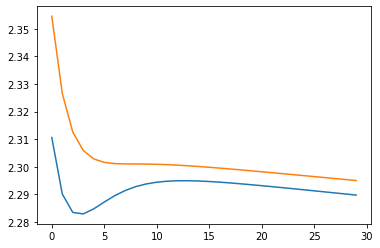

In [26]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=100)
get_mini_batch_val = GetMiniBatch(X_val, y_val, batch_size=100)
sdn = ScratchDeepNeuralNetrowkClassifier()
sdn.fit()

train_loss_list1 = []
train_loss_list2 = []
epocs = 30
for _ in range(epocs):
    for mini_X_train, mini_y_train in get_mini_batch:
        mini_X_train = np.array(mini_X_train)
        mini_y_train = np.array(mini_y_train)
        if mini_X_train.ndim == 1:
            mini_X_train = mini_X_train[:, np.newaxis]
            
        if mini_y_train.ndim == 1:
            mini_y_train = mini_y_train[:, np.newaxis]
        Z = sdn.predict(mini_X_train)

        sdn.backward(Z,mini_y_train)
    train_loss_list1.append(sdn.loss)
    
    for mini_X_val, mini_y_val in get_mini_batch_val:
        mini_X_val = np.array(mini_X_val)
        mini_y_val = np.array(mini_y_val)
        if mini_X_val.ndim == 1:
            mini_X_val = mini_X_val[:, np.newaxis]
            
        if mini_y_val.ndim == 1:
            mini_y_val = mini_y_val[:, np.newaxis]
        Z = sdn.predict(mini_X_val)

        sdn.backward(Z,mini_y_val)
    train_loss_list2.append(sdn.loss)

plt.plot(train_loss_list1)
plt.plot(train_loss_list2)
plt.show()

In [39]:
y_pred = sdn.predict(X_test)

In [40]:
y_pre= np.argmax(y_pred,axis=1)

In [41]:
y_true = np.argmax(y_test,axis=1)

In [42]:
accuracy_score(y_true, y_pre)

0.1135